In [112]:
import numpy as np
import rootutils

root = rootutils.setup_root(search_from=".", indicator=".git")

DATA_DIR_TRAIN = root / "data" / "DL" / "TRAIN"
DATA_DIR_TEST = root / "data" / "DL" / "TEST"

In [113]:
dl_data_path_train = DATA_DIR_TRAIN / "dl_data_train.npz"
dl_data_path_test = DATA_DIR_TEST / "dl_data_test.npz"
dl_data_train = np.load(dl_data_path_train, allow_pickle=True)
dl_data_test = np.load(dl_data_path_test, allow_pickle=True)

In [114]:
print(dl_data_train)
print("Keys:", dl_data_train.files)
for key in dl_data_train.files:
    print(f"{key}: shape={dl_data_train[key].shape}, dtype={dl_data_train[key].dtype}")

print(dl_data_test)
print("Keys:", dl_data_test.files)
for key in dl_data_test.files:
    print(f"{key}: shape={dl_data_test[key].shape}, dtype={dl_data_test[key].dtype}")

NpzFile '/home/arian/cdl1/CDL1-MChallenge/data/DL/TRAIN/dl_data_train.npz' with keys: X, y
Keys: ['X', 'y']
X: shape=(3699, 250, 20), dtype=float32
y: shape=(3699,), dtype=object
NpzFile '/home/arian/cdl1/CDL1-MChallenge/data/DL/TEST/dl_data_test.npz' with keys: X, y
Keys: ['X', 'y']
X: shape=(1253, 250, 20), dtype=float32
y: shape=(1253,), dtype=object


CNN
LSTM
MLP

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Prepare data
X = dl_data_train['X']  # shape: (N, T, C) or (N, C, T)
y = dl_data_train['y']  # shape: (N,)

# If y is object dtype or string, encode to integer labels
if y.dtype.kind in {'U', 'S', 'O'} or not np.issubdtype(y.dtype, np.integer):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
else:
    le = None  # No label encoding needed

if X.shape[1] < X.shape[2]:  # (N, T, C) -> (N, C, T)
    X = np.transpose(X, (0, 2, 1))

X = X.astype(np.float32)
y = y.astype(np.int64)
num_classes = len(np.unique(y))

# Convert to torch tensors
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

# Split into train, val, test (e.g., 80/10/10)
N = X.shape[0]
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val
dataset = TensorDataset(X_tensor, y_tensor)
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

Label mapping: {'climbing': np.int64(0), 'joggen': np.int64(1), 'sitting': np.int64(2), 'walking': np.int64(3)}


In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import wandb
import os
import json
import pandas as pd

config = {
    "project": "cdl1",
    "run_name": "cnn-batchsize-64",
    "in_channels": X.shape[1],          
    "num_classes": num_classes,          
    "epochs": 10,
    "batch_size": batch_size,
    "lr": 1e-3,
    "cnn_channels": 4,
    "kernel_size": 3,
    "use_wandb": True,
    "log_dir": "../data/log"
}

history_dir = os.path.join(config["log_dir"], "history")
os.makedirs(history_dir, exist_ok=True)

In [130]:
def save_history(history, config, test_metrics=None, filetype="json"):
    # Füge Test-Metriken zur History hinzu
    if test_metrics is not None:
        history["test_metrics"] = {
            "test_accuracy": test_metrics[0],
            "test_precision": test_metrics[1],
            "test_recall": test_metrics[2],
            "test_f1": test_metrics[3],
        }

    # Zielpfad
    filename = f"{config['run_name']}.{filetype}"
    filepath = os.path.join(config["log_dir"], "history", filename)

    # Speichern
    if filetype == "json":
        with open(filepath, "w") as f:
            json.dump(history, f, indent=4)
    elif filetype == "csv":
        df = pd.DataFrame(history)
        df.to_csv(filepath, index=False)
        if test_metrics is not None:
            print("Hinweis: Test-Metriken sind **nicht** in CSV enthalten – besser JSON verwenden.")
    else:
        raise ValueError("Unsupported file type. Use 'json' or 'csv'.")

### CNN Model

In [131]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_classes):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

#### Training

In [132]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, config):
    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))
        print(f"[Epoch {epoch+1}/{config['epochs']}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if config["use_wandb"]:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_acc": val_acc,
            })

    return model, history

#### Evaluation

In [133]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    return acc, prec, rec, f1, y_true, y_pred

# Training

In [151]:
# Wandb init
if config["use_wandb"]:
    os.makedirs(config["log_dir"], exist_ok=True)
    wandb.init(
        project=config["project"],
        name=config["run_name"],
        config=config,
        dir=config["log_dir"]
    )

# Device & Modell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(
    in_channels=config["in_channels"],
    out_channels=config["cnn_channels"],
    kernel_size=config["kernel_size"],
    num_classes=config["num_classes"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# Training
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, config)

# Evaluation
acc, prec, rec, f1, y_true, y_pred = evaluate_model(model, test_loader, device)

# Logging final test metrics
if config["use_wandb"]:
    wandb.log({
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1": f1,
    })
    wandb.finish()

# Falls LabelEncoder verwendet wurde:
if 'le' in globals() and le is not None:
    y_true_labels = le.inverse_transform(y_true)
    y_pred_labels = le.inverse_transform(y_pred)
    print("\nExample true labels:", y_true_labels[:6])
    print("Example predicted labels:", y_pred_labels[:6])


# Save training history
save_history(history, config, test_metrics=(acc, prec, rec, f1), filetype="json")

[Epoch 1/10] Train Loss: 1.4582, Val Loss: 0.7768, Val Acc: 0.6233
[Epoch 2/10] Train Loss: 0.8032, Val Loss: 0.6947, Val Acc: 0.6856
[Epoch 3/10] Train Loss: 0.7556, Val Loss: 0.6604, Val Acc: 0.7073
[Epoch 4/10] Train Loss: 0.7528, Val Loss: 0.6130, Val Acc: 0.7182
[Epoch 5/10] Train Loss: 0.7468, Val Loss: 0.6226, Val Acc: 0.7398
[Epoch 6/10] Train Loss: 0.7397, Val Loss: 0.6104, Val Acc: 0.7724
[Epoch 7/10] Train Loss: 0.7249, Val Loss: 0.6258, Val Acc: 0.6856
[Epoch 8/10] Train Loss: 0.7178, Val Loss: 0.6066, Val Acc: 0.8022
[Epoch 9/10] Train Loss: 0.7079, Val Loss: 0.6100, Val Acc: 0.7236
[Epoch 10/10] Train Loss: 0.7171, Val Loss: 0.5807, Val Acc: 0.8076

Test Accuracy: 0.7385
Test Precision: 0.7525
Test Recall: 0.7385
Test F1-score: 0.7431


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▇▃█▅█
val_loss,█▅▄▂▂▂▃▂▂▁
epoch,10
test_accuracy,0.73854
test_f1,0.74309



Example true labels: ['sitting' 'walking' 'joggen' 'sitting' 'climbing' 'joggen']
Example predicted labels: ['sitting' 'walking' 'joggen' 'climbing' 'climbing' 'joggen']


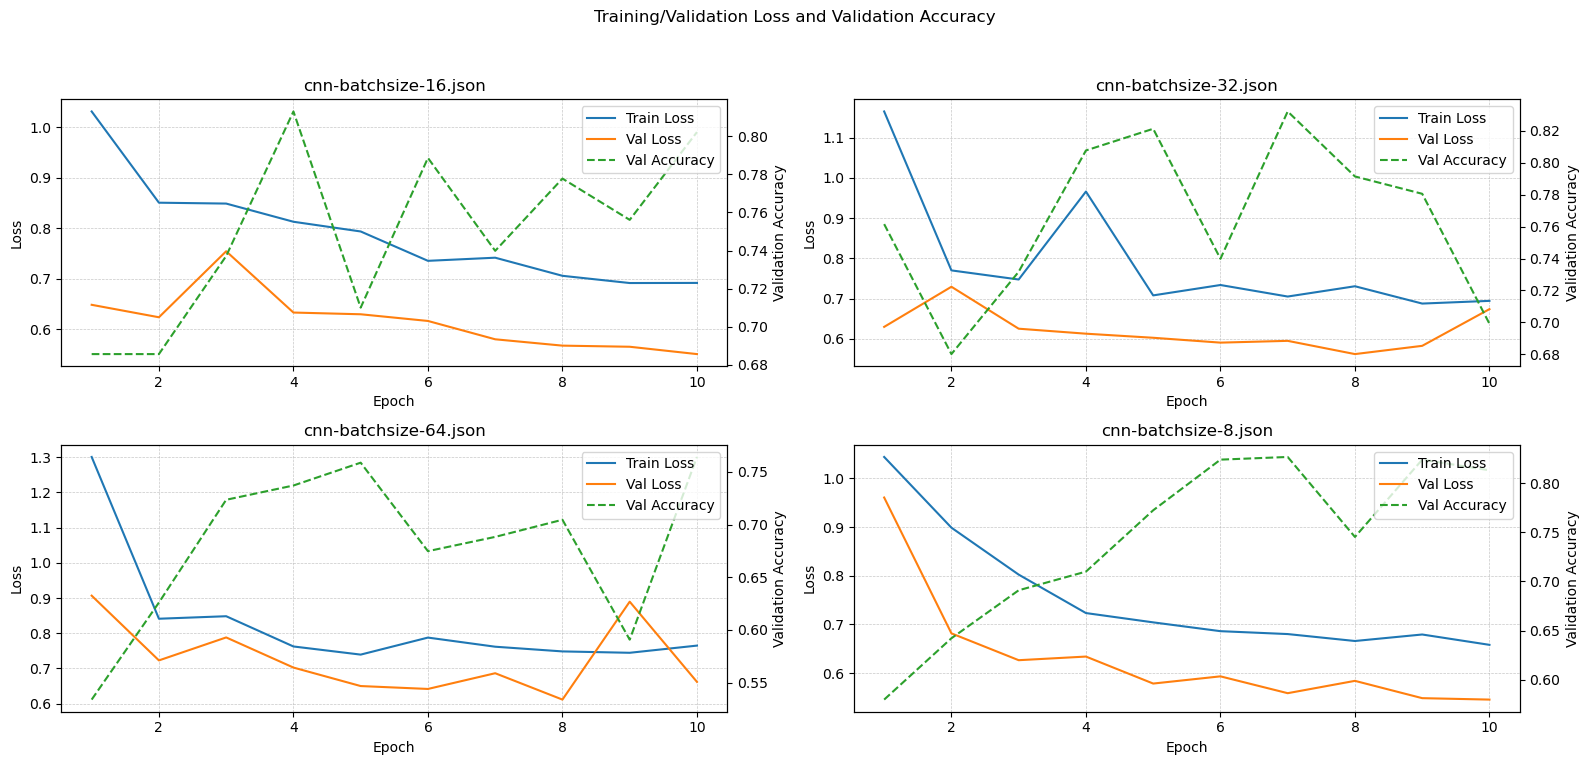

In [91]:
import os
import json
import matplotlib.pyplot as plt

history_dir = "../data/log/history"
json_files = sorted([f for f in os.listdir(history_dir) if f.endswith(".json")])

max_cols = 2
num_files = len(json_files)
if num_files == 0:
    print("No history files found.")
else:
    # Calculate number of rows needed
    nrows = (num_files + max_cols - 1) // max_cols
    fig, axes = plt.subplots(nrows=nrows, ncols=max_cols, figsize=(8 * max_cols, 4 * nrows))
    # axes is 2D array if nrows > 1, else 1D
    if nrows == 1:
        axes = [axes]
    axes = [ax for row in axes for ax in (row if isinstance(row, (list, np.ndarray)) else [row])]

    for idx, json_file in enumerate(json_files):
        json_path = os.path.join(history_dir, json_file)
        with open(json_path, "r") as f:
            history = json.load(f)

        epochs = history['epoch'] if 'epoch' in history else list(range(1, len(history['val_loss'])+1))

        ax = axes[idx]
        # Plot Losses
        ax.plot(epochs, history['train_loss'], label='Train Loss', color='tab:blue', linestyle='-')
        ax.plot(epochs, history['val_loss'], label='Val Loss', color='tab:orange', linestyle='-')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax2 = ax.twinx()
        ax2.plot(epochs, history['val_acc'], label='Val Accuracy', color='tab:green', linestyle='--')
        ax2.set_ylabel('Validation Accuracy')
        # Legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_title(f'{json_file}')

    # Hide any unused axes
    for j in range(num_files, nrows * max_cols):
        fig.delaxes(axes[j])

    plt.suptitle('Training/Validation Loss and Validation Accuracy')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Analyse der Batch Size

### Bewertungskriterien
- **Validation Accuracy (grüne gestrichelte Linie)**: Primäres Maß für Generalisierung.
- **Validation Loss (orange Linie)**: Sekundär; hilft zu erkennen, ob das Modell stabil und nicht überfit ist.
- **Train Loss**: Interessant für Overfitting-Erkennung.

---

### Analyse der getesteten Batch Sizes

#### Batch Size = 8
- Höchste **Validation Accuracy** (~0.83 über mehrere Epochen)
- Sehr niedrige und stabile **Validation Loss**
- Trainiert stabil, kein starkes Overfitting sichtbar
- **→ Bestes Gleichgewicht aus Genauigkeit und Stabilität**

#### Batch Size = 16
- Solide Accuracy (~0.78), aber etwas unter Batch Size 8
- Validation Loss fluktuiert stärker
- Gut, aber nicht besser als Batch 8

#### Batch Size = 32
- Unstetige **Validation Accuracy**, sinkt am Ende leicht
- Geringere Generalisierung als Batch Size 8 oder 16
- Val Loss stabil, aber Accuracy zu inkonsistent

#### Batch Size = 64
- Schlechteste **Validation Accuracy** (~0.74 Peak, sinkt auf ~0.55)
- Höchste Validation Loss
- Modell generalisiert hier schlecht
- **→ Nicht gut**

---

### Verwedung
**→ Ich werde `batch_size = 8`** für weitere Experimente:

- Beste und stabilste Validation Accuracy
- Kein Anzeichen von Overfitting
- Geringe und stabile Validation Loss

In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Directory containing the JSON files
log_dir = "../data/log/history"
# List of learning rates (assuming you know them or can glob the files)
lr_list = ["1e-2", "5e-3", "1e-3", "5e-4", "1e-4"]
json_files = [f"cnn-bs_8-lr_{lr}.json" for lr in lr_list]

# Load all histories
histories = []
for fname in json_files:
    path = os.path.join(log_dir, fname)
    with open(path, "r") as f:
        histories.append((fname, json.load(f)))

# Plotting
n_files = len(histories)
n_cols = 2
n_rows = (n_files + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows), squeeze=False)
for idx, (fname, hist) in enumerate(histories):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]
    epochs = hist["epoch"]
    ax.plot(epochs, hist["train_loss"], label="Train Loss", color="blue")
    ax.plot(epochs, hist["val_loss"], label="Val Loss", color="orange")
    ax.plot(epochs, hist["val_acc"], label="Val Acc", color="green", linestyle="dashed")
    ax.set_title(fname)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss / Accuracy")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for idx in range(n_files, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row][col].axis("off")

plt.tight_layout()
plt.show()


---

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, 2, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(2, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [40]:
class CNN2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNN(in_channels=X.shape[1], num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda


In [48]:
import wandb
import os

# Ensure the log directory exists
os.makedirs("../data/log", exist_ok=True)

# Initialize wandb with custom log directory
wandb.init(
    project="cdl1",
    name="simple-cnn-CNN2",
    config={
        "epochs": 10,
        "batch_size": batch_size,
        "optimizer": "Adam",
        "lr": 1e-3,
        "model": "SimpleCNN",
        "in_channels": X.shape[1],
        "num_classes": num_classes,
    },
    dir="../data/log"
)

In [49]:
# Initialize lists to store metrics for plotting outside the function
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
}

# Training loop with wandb logging
def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val acc: {val_acc:.4f}")

        # Save metrics for plotting
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_acc,
        })

In [50]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10 - Train loss: 0.1159 - Val loss: 0.1069 - Val acc: 0.9648
Epoch 2/10 - Train loss: 0.1004 - Val loss: 0.1262 - Val acc: 0.9702
Epoch 3/10 - Train loss: 0.0976 - Val loss: 0.0992 - Val acc: 0.9729
Epoch 4/10 - Train loss: 0.0940 - Val loss: 0.0862 - Val acc: 0.9810
Epoch 5/10 - Train loss: 0.0785 - Val loss: 0.0991 - Val acc: 0.9783
Epoch 6/10 - Train loss: 0.0777 - Val loss: 0.0867 - Val acc: 0.9756
Epoch 7/10 - Train loss: 0.0754 - Val loss: 0.0748 - Val acc: 0.9864
Epoch 8/10 - Train loss: 0.0622 - Val loss: 0.0817 - Val acc: 0.9756
Epoch 9/10 - Train loss: 0.0567 - Val loss: 0.0735 - Val acc: 0.9783
Epoch 10/10 - Train loss: 0.0544 - Val loss: 0.0656 - Val acc: 0.9783


{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'train_loss': [0.11591786507739937,
  0.1003506347768691,
  0.09757797761457358,
  0.09400323039501775,
  0.07853690886082541,
  0.0777108888228365,
  0.07542469668359159,
  0.06218833505576045,
  0.056659198749776464,
  0.05439163541724076],
 'val_loss': [0.10693309554037686,
  0.12616055769729745,
  0.0991915055326007,
  0.08620795915483782,
  0.09914793506224304,
  0.08668481934119046,
  0.07483683777897339,
  0.08172879499310078,
  0.07354232924801063,
  0.06560800234638256],
 'val_acc': [0.964769647696477,
  0.9701897018970189,
  0.9728997289972899,
  0.981029810298103,
  0.978319783197832,
  0.975609756097561,
  0.986449864498645,
  0.975609756097561,
  0.978319783197832,
  0.978319783197832]}

In [ ]:
# Evaluation on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.cpu().numpy())
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Log test metrics to wandb
wandb.log({
    "test_accuracy": acc,
    "test_precision": prec,
    "test_recall": rec,
    "test_f1": f1,
})

# If you want to map predictions back to string labels:
if le is not None:
    y_true_labels = le.inverse_transform(y_true)
    y_pred_labels = le.inverse_transform(y_pred)
    print("Example true labels:", y_true_labels[:6])
    print("Example predicted labels:", y_pred_labels[:6])

wandb.finish()

Test Accuracy: 0.9380
Test Precision: 0.9425
Test Recall: 0.9380
Test F1-score: 0.9390
Example true labels: ['sitting' 'walking' 'joggen' 'sitting' 'climbing' 'joggen' 'walking'
 'climbing' 'sitting' 'walking']
Example predicted labels: ['sitting' 'walking' 'joggen' 'sitting' 'climbing' 'joggen' 'walking'
 'climbing' 'sitting' 'walking']


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▅▄▃▃▂▂▁▂▁
val_acc,▁▄▃▃▇▆▆▇▇█
val_loss,█▆▆▆▃▃▂▂▂▁
epoch,10
test_accuracy,0.93801
test_f1,0.939


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss and validation accuracy
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.title("Training History")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)


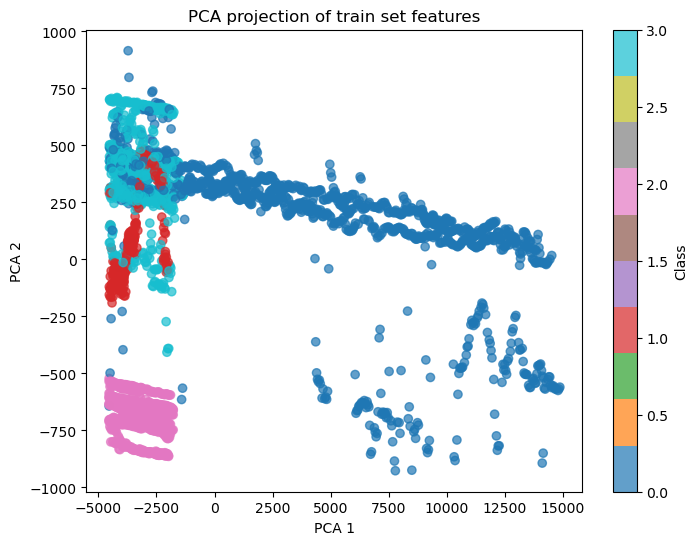

In [13]:
# UMAP and pynndescent are currently incompatible with numpy>=2.0 due to use of np.infty.
# As a workaround, use PCA for visualization instead of UMAP.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Helper to get features from the penultimate layer
def get_penultimate_features(model, xb):
    """
    Try to extract features from the penultimate layer of the model.
    This function handles common model architectures.
    """
    # If model has a feature extractor, use it
    if hasattr(model, 'features'):
        feats = model.features(xb)
    elif hasattr(model, 'extract_features'):
        feats = model.extract_features(xb)
    else:
        # Try to find the last nn.Linear layer before the classifier
        # This works for models with a 'classifier' or 'fc' attribute that is nn.Sequential or nn.ModuleList
        if hasattr(model, 'classifier') and isinstance(model.classifier, torch.nn.Sequential):
            modules = list(model.classifier.children())
            if len(modules) > 1:
                penultimate = torch.nn.Sequential(*modules[:-1])
                feats = penultimate(xb)
            else:
                feats = xb
        elif hasattr(model, 'fc') and isinstance(model.fc, torch.nn.Sequential):
            modules = list(model.fc.children())
            if len(modules) > 1:
                penultimate = torch.nn.Sequential(*modules[:-1])
                feats = penultimate(xb)
            else:
                feats = xb
        elif hasattr(model, 'fc') and isinstance(model.fc, torch.nn.Linear):
            # Instead of calling model.fc(xb), call the model up to the penultimate layer
            # Try to find the layer before 'fc'
            # This is a best-effort fallback: run the model up to the last layer
            # If model has a 'forward_features' method, use it
            if hasattr(model, 'forward_features'):
                feats = model.forward_features(xb)
            else:
                # As a last resort, remove the last layer from model._modules if possible
                # This is fragile and may not work for all models
                # So just use the input
                feats = xb
        else:
            feats = xb  # fallback to input
    return feats

# Get the features from the train set
model.eval()
train_features = []
train_labels = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        feats = get_penultimate_features(model, xb)
        feats = feats.view(feats.size(0), -1).cpu().numpy()
        train_features.append(feats)
        train_labels.append(yb.cpu().numpy())
train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

# PCA projection (2D)
pca = PCA(n_components=2, random_state=42)
embedding = pca.fit_transform(train_features)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=train_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.title('PCA projection of train set features')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()